In [1]:
import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import DDIMScheduler
from huggingface_hub import hf_hub_download

from photomaker import PhotoMakerStableDiffusionXLPipeline

2024-01-14 13:06:44.852659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 13:06:45.609743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize
    
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = './civitai_models/sdxlUnstableDiffusers_v11.safetensors'
photomaker_path = './release_model/photomaker-v1.bin'
lora_path = './civitai_models/xl_more_art-full.safetensors'

device = "cuda"
save_path = "./outputs"

In [3]:
# Load base model
pipe = PhotoMakerStableDiffusionXLPipeline.from_single_file(
    base_model_path, 
    torch_dtype=torch.bfloat16, 
    original_config_file=None,
).to(device)

# Load PhotoMaker checkpoint
pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_path),
    subfolder="",
    weight_name=os.path.basename(photomaker_path),
    trigger_word="img"
)     

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
print("Loading lora...")
pipe.load_lora_weights(os.path.dirname(lora_path), weight_name=os.path.basename(lora_path), adapter_name="xl_more_art-full")
pipe.set_adapters(["photomaker", "xl_more_art-full"], adapter_weights=[1.0, 0.5])
pipe.fuse_lora()

Loading PhotoMaker components [1] id_encoder from [./release_model]...
Loading PhotoMaker components [2] lora_weights from [./release_model]
Loading lora...


Input ID images:


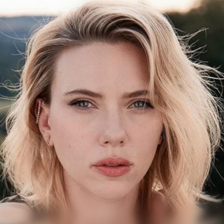

In [4]:
# define and show the input ID images
image_path = './examples/scarletthead_woman/scarlett_0.jpg'

input_id_images = []
input_id_images.append(load_image(image_path))
    
input_grid = image_grid(input_id_images, 1, 1, size_after_resize=224)
print("Input ID images:")
input_grid

In [5]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "A girl img riding dragon over a whimsical castle, 3d CGI, art by Pixar, half-body, screenshot from animation"
negative_prompt = "realistic, photo-realistic, bad quality, bad anatomy, worst quality, low quality, lowres, extra fingers, blur, blurry, ugly, wrong proportions, watermark, image artifacts, bad eyes, bad hands, bad arms"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30
    
images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=4,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
).images

torch.Size([1, 2048]) torch.Size([1, 2048])


  0%|          | 0/50 [00:00<?, ?it/s]

Results:


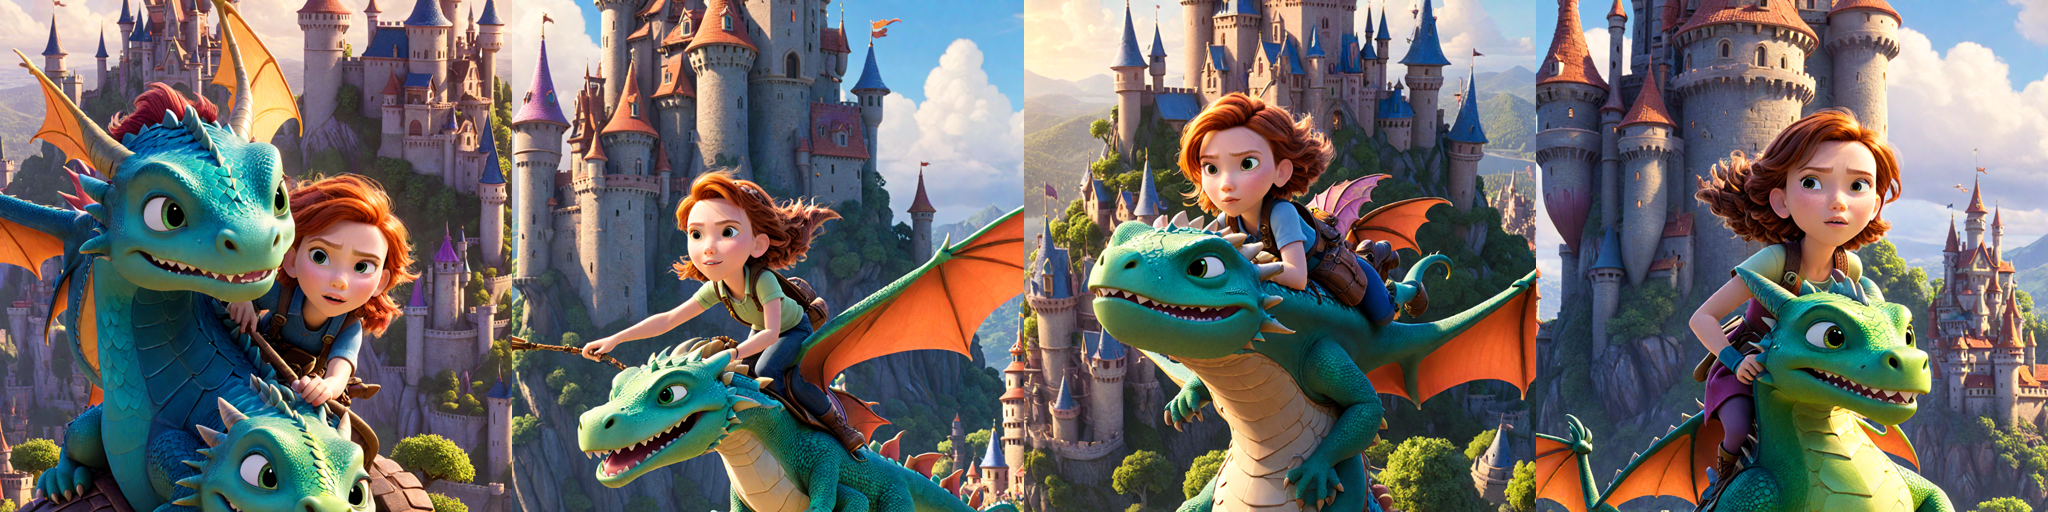

In [6]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 4, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_style_{idx:02d}.png"))
    
print("Results:")
grid